# Data Cleaning
Penelitian "PENERAPAN MACHINE LEARNING UNTUK ESTIMASI REMAINING USEFUL LIFE (RUL) ROLLER PADA TOP WEIGHTING ARM MESIN RING SPINNING (STUDI KASUS PT. XYZ)" - Hanindita Jati (2025)

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Baca Data
data = pd.read_excel('DATAMODEL_2.xlsx', sheet_name='Sheet4x3') # pake data yg ada outlier jelas di excel
data = data.drop(columns=['ipi', 'ap']) # kolom rsf (udah bener tapi masi v1) dan ap belum bener, jadi diabaikan dulu

data_awal = pd.read_excel('DATAMODEL_2.xlsx', sheet_name='Sheet4x3')
data_awal = data_awal.drop(columns=['ipi', 'ap']) 

print(f'data.shape : {data.shape}\n')
print(data.info())
data.head(2)

data.shape : (447, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    447 non-null    datetime64[ns]
 1   RSF     447 non-null    object        
 2   ne      447 non-null    int64         
 3   u       447 non-null    float64       
 4   cvm     447 non-null    float64       
 5   cv1m    447 non-null    float64       
 6   thin    447 non-null    int64         
 7   thick   447 non-null    int64         
 8   neps    447 non-null    int64         
 9   ha      447 non-null    float64       
 10  D1      447 non-null    float64       
 11  D2      447 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 42.0+ KB
None


Date RSF  ne     u    cvm  cv1m  thin  thick  neps    ha    D1    D2
0 2024-02-01  1C  28  8.82  11.09  3.31     0      2     2  3.87  30.0  28.5
1 2024-02-01  1D  40  9.85  12.42  4.80     0      8    10  4.12  30.0  28.5

## Interpolasi Data

Metode PCHIP merupakan interpolasi kubik yang menjaga bentuk asli data (shape-preserving). Cocok untuk data kontinu seperti ukuran dan nilai numerik di kolom ini karena memastikan kelancaran kurva tanpa menciptakan nilai ekstrem. Metode interpolasi PCHIP digunakan pada kolom ['D1', 'D2', 'u', 'cvm', 'cv1m', 'ha', 'thin', 'thick', 'neps']

- Fritsch, F. N., & Butland, J. (1984). A Method for Constructing Local Monotone Piecewise Cubic Interpolants. SIAM Journal on Scientific and Statistical Computing, 5(2), 300–304.
https://doi.org/10.1137/0905021

Metode interpolasi nearest-neighbor digunakan untuk menjaga keutuhan data diskrit. Konsep ini cocok diterapkan pada data kategorikal atau diskrit seperti pada kolom ['ne'], dimana nearest‑neighbor menghindari pembuatan nilai yang tidak ada dalam data asli.

- Etherington, T. R. (2022). The role of spatial interpolation in biodiversity analyses. Biometrics, 78(4), 1454–1464. https://doi.org/10.1111/biom.13505

In [3]:
FREQ = 'D'

data_interpolated = data.copy()
data_interpolated['Date'] = pd.to_datetime(data_interpolated['Date'])

interpolated_list = []

for rsf_value in data_interpolated['RSF'].unique():
    df_rsf = data_interpolated[data_interpolated['RSF'] == rsf_value].copy()
    df_rsf = df_rsf.sort_values(by='Date')

    # Gunakan semua data untuk interpolasi penuh (harian)
    full_date_range = pd.date_range(start=df_rsf['Date'].min(), end=df_rsf['Date'].max(), freq='D')

    df_rsf.set_index('Date', inplace=True)
    df_rsf = df_rsf.groupby(df_rsf.index).first()  # Ambil satu data per tanggal jika duplikat
    df_rsf = df_rsf.reindex(full_date_range)  # Tidak isi NaN di sini
    df_rsf.index.name = 'Date'

    # Interpolasi
    pchip_cols = ['D1', 'D2', 'u', 'cvm', 'cv1m', 'ha']
    ipi_cols = ['thin', 'thick', 'neps']
    ne_cols = ['ne']

    for col in pchip_cols:
        if col in df_rsf.columns:
            df_rsf[col] = df_rsf[col].interpolate(method='pchip').round(3)

    for col in ipi_cols:
        if col in df_rsf.columns:
            df_rsf[col] = df_rsf[col].interpolate(method='pchip').round()
            df_rsf[col] = df_rsf[col].fillna(0).astype(int)

    for col in ne_cols:
        if col in df_rsf.columns:
            df_rsf[col] = df_rsf[col].interpolate(method='nearest')

    # Sampling hasil interpolasi tiap FREKUENSI
    df_sampled = df_rsf.resample(FREQ).first().dropna(how='all')  # Bisa juga gunakan .mean()

    df_sampled['RSF'] = rsf_value
    df_sampled.reset_index(inplace=True)  # Kembalikan Date jadi kolom

    interpolated_list.append(df_sampled)

# Gabungkan semua hasil interpolasi dan sampling
data_final = pd.concat(interpolated_list, ignore_index=True)
data = data_final.sort_values(by=['RSF', 'Date'])

data

Date  RSF    ne       u     cvm   cv1m  thin  thick  neps     ha  \
20327 2024-03-14  10A  40.0   9.410  11.830  3.750     0      2     9  3.920   
20328 2024-03-15  10A  40.0   9.416  11.839  3.764     0      2     9  3.917   
20329 2024-03-16  10A  40.0   9.422  11.847  3.778     0      2     9  3.915   
20330 2024-03-17  10A  40.0   9.428  11.856  3.792     0      2     9  3.912   
20331 2024-03-18  10A  40.0   9.433  11.864  3.806     0      2     9  3.910   
...          ...  ...   ...     ...     ...    ...   ...    ...   ...    ...   
7097  2025-03-08   9D  30.0  10.099  12.827  3.788     0      4     7  4.027   
7098  2025-03-09   9D  30.0  10.104  12.835  3.806     0      4     7  4.025   
7099  2025-03-10   9D  30.0  10.109  12.843  3.823     0      4     7  4.023   
7100  2025-03-11   9D  30.0  10.115  12.852  3.842     0      4     7  4.022   
7101  2025-03-12   9D  30.0  10.120  12.860  3.860     0      4     7  4.020   

           D1      D2  
20327  30.000  28.600  
20328  29.995  28.598  
20329  29.991  28.596  
20330  29.986  28.594  
20331  29.982  28.592  
...       ...     ...  
7097   28.710  27.818  
7098   28.708  27.813  
7099   28.705  27.809  
7100   28.703  27.805  
7101   28.700  27.800  

[23700 rows x 12 columns]

In [4]:
data.isnull().sum()

Date     0
RSF      0
ne       0
u        0
cvm      0
cv1m     0
thin     0
thick    0
neps     0
ha       0
D1       0
D2       0
dtype: int64

Tidak ada data yang null atau kosong.

## Menangani Outlier (IQR) dengan Winsorizing

Winsorizing digunakan karena nilai outlier diganti dengan nilai batas atas dan batas bawah yang diperoleh dari metode interquartile range (IQR). Sehingga tidak terjadi kehilangan data setelah interpolasi.

- Zubedi, A., Siregar, M., & Sari, R. M. (2022). Winsorizing outliers with interquartile range in HDI analysis using Random Forest. Jurnal Natural, 22(2), 72–80. https://doi.org/10.24815/jn.v22i2.25499

In [5]:
def detect_outliers_iqr(df):
    outlier_summary = {}
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]

        outlier_summary[col] = {
            "outlier_count": outlier_count,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by='outlier_count', ascending=False)

def handle_outliers_iqr(df, method='drop'):
    """
    Mengatasi outlier menggunakan metode IQR.
    Parameter:
    - df: DataFrame
    - method: 'drop' atau 'replace' (replace = winsorize)
    """

    df_cleaned = df.copy()
    numeric_cols = df_cleaned.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'drop':
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        elif method == 'replace':
            df_cleaned[col] = df_cleaned[col].apply(
                lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
            )
        else:
            raise ValueError("Metode tidak dikenali. Gunakan 'drop' atau 'replace'.")

    return df_cleaned

Outlier per Kolom:
       outlier_count  lower_bound  upper_bound
thin            90.0       0.0000       0.0000
ne              84.0      15.0000      39.0000
cv1m            20.0       2.7350       4.6950
thick           11.0      -5.0000      11.0000
neps             9.0      -5.5000      14.5000
ha               2.0       3.1500       5.4700
u                0.0       6.5625      11.4625
cvm              0.0       8.2725      14.4125
D1               0.0      28.2375      30.7375
D2               0.0      27.4750      28.8750
(447, 12)


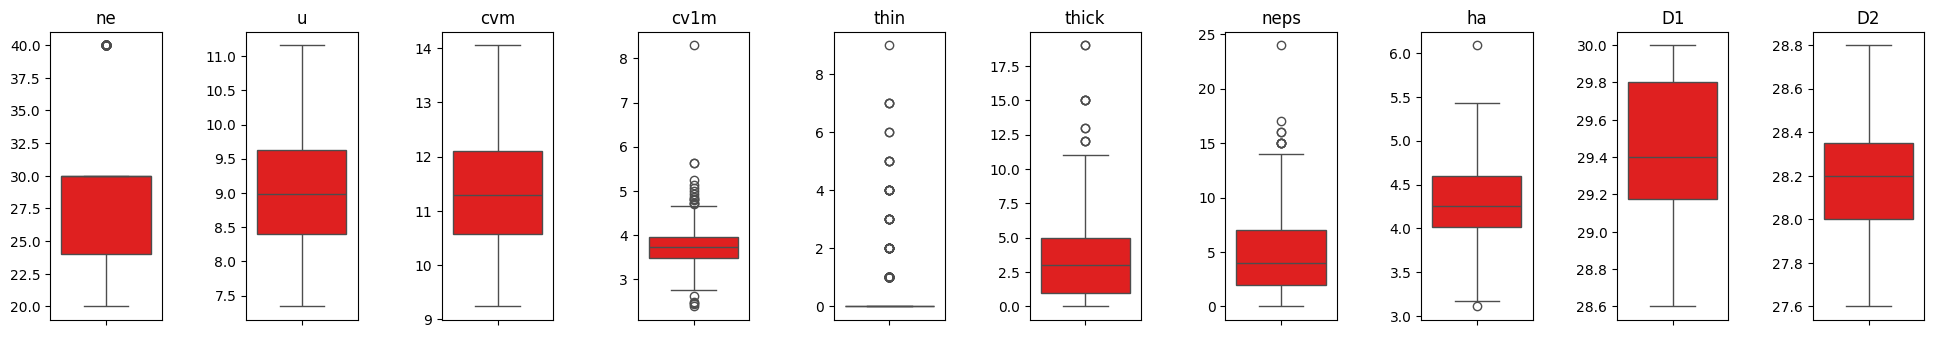

Outlier per Kolom:
       outlier_count  lower_bound  upper_bound
ne               0.0     0.000000    64.000000
u                0.0     6.372000    12.180000
cvm              0.0     8.068625    15.357625
cv1m             0.0     2.821000     4.749000
thin             0.0    -1.500000     2.500000
thick            0.0    -4.000000    12.000000
neps             0.0    -4.500000    15.500000
ha               0.0     3.280000     5.232000
D1               0.0    28.198500    30.578500
D2               0.0    27.394000    28.890000
(23700, 12)


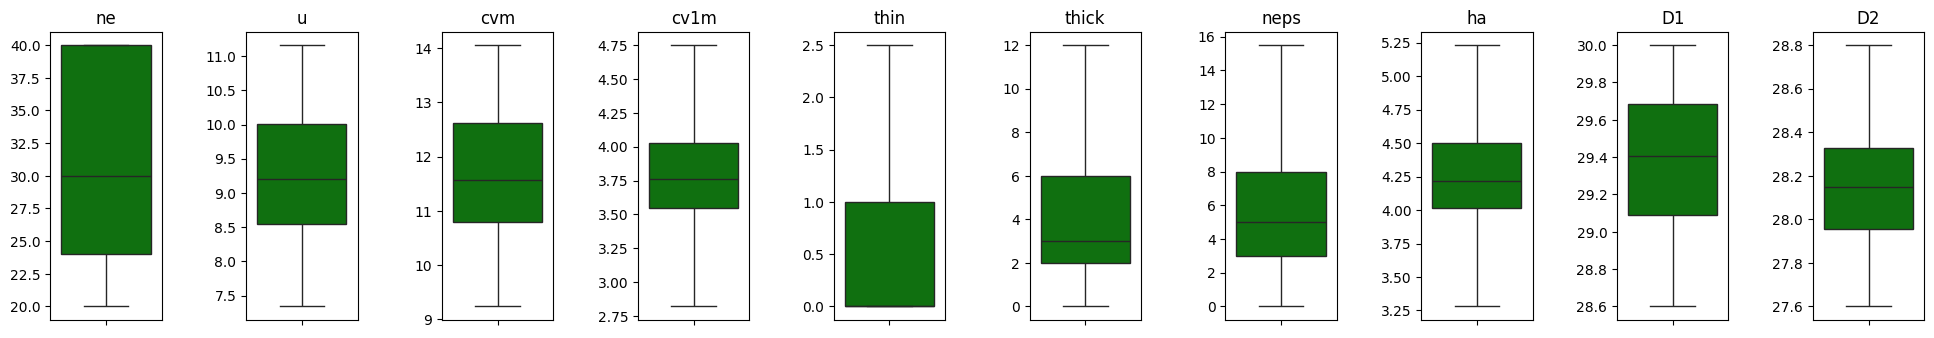

In [6]:
outlier_report2 = detect_outliers_iqr(data_awal)

print("Outlier per Kolom:")
print(outlier_report2)
print(f'{data_awal.shape}')

num_cols = data_awal.select_dtypes(include='number').columns
n_cols = len(num_cols)

fig, axes = plt.subplots(1, n_cols, figsize=(2*n_cols, 4))
fig.tight_layout(pad=3.0)

for i, col in enumerate(num_cols):
    sns.boxplot(y=data_awal[col], ax=axes[i], color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.show()


data = handle_outliers_iqr(data, method='replace')
outlier_report = detect_outliers_iqr(data)

print("Outlier per Kolom:")
print(outlier_report)
print(f'{data.shape}')

num_cols = data.select_dtypes(include='number').columns
n_cols = len(num_cols)

fig, axes = plt.subplots(1, n_cols, figsize=(2*n_cols, 4))
fig.tight_layout(pad=3.0)

for i, col in enumerate(num_cols):
    sns.boxplot(y=data[col], ax=axes[i], color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.show()

Terlihat bahwa outlier sudah tidak muncul lagi pada data, serta bentuk data tetap utuh seperti data sebelum winsorizing.

## Statistik Deskriptif

In [7]:
data_awal.describe()

Date          ne          u         cvm  \
count                            447  447.000000  447.00000  447.000000   
mean   2024-08-17 03:16:30.604026880   28.543624    9.07094   11.427740   
min              2024-02-01 00:00:00   20.000000    7.34000    9.240000   
25%              2024-05-03 00:00:00   24.000000    8.40000   10.575000   
50%              2024-08-13 00:00:00   30.000000    8.99000   11.300000   
75%              2024-11-18 00:00:00   30.000000    9.62500   12.110000   
max              2025-03-26 00:00:00   40.000000   11.16000   14.050000   
std                              NaN    6.596796    0.86583    1.098623   

             cv1m        thin       thick        neps          ha          D1  \
count  447.000000  447.000000  447.000000  447.000000  447.000000  447.000000   
mean     3.750492    0.436242    3.498881    5.022371    4.339128   29.425839   
min      2.380000    0.000000    0.000000    0.000000    3.110000   28.600000   
25%      3.470000    0.000000    1.000000    2.000000    4.020000   29.175000   
50%      3.720000    0.000000    3.000000    4.000000    4.260000   29.400000   
75%      3.960000    0.000000    5.000000    7.000000    4.600000   29.800000   
max      8.300000    9.000000   19.000000   24.000000    6.090000   30.000000   
std      0.485054    1.177073    3.199548    3.774999    0.433865    0.389763   

               D2  
count  447.000000  
mean    28.158166  
min     27.600000  
25%     28.000000  
50%     28.200000  
75%     28.350000  
max     28.800000  
std      0.251220

In [8]:
data.describe()

Date            ne             u  \
count                          23700  23700.000000  23700.000000   
mean   2024-08-27 11:29:51.797468416     30.103460      9.257707   
min              2024-02-01 00:00:00     20.000000      7.340000   
25%              2024-05-27 00:00:00     24.000000      8.550000   
50%              2024-08-27 00:00:00     30.000000      9.196000   
75%              2024-11-28 00:00:00     40.000000     10.002000   
max              2025-03-26 00:00:00     40.000000     11.160000   
std                              NaN      7.273619      0.873670   

                cvm          cv1m          thin         thick          neps  \
count  23700.000000  23700.000000  23700.000000  23700.000000  23700.000000   
mean      11.664955      3.795468      0.417869      4.035612      5.636013   
min        9.240000      2.821000      0.000000      0.000000      0.000000   
25%       10.802000      3.544000      0.000000      2.000000      3.000000   
50%       11.564000      3.765000      0.000000      3.000000      5.000000   
75%       12.624250      4.026000      1.000000      6.000000      8.000000   
max       14.050000      4.749000      2.500000     12.000000     15.500000   
std        1.107307      0.372578      0.775998      3.140156      3.704767   

                 ha            D1            D2  
count  23700.000000  23700.000000  23700.000000  
mean       4.298774     29.386969     28.149548  
min        3.280000     28.600000     27.600000  
25%        4.012000     29.091000     27.955000  
50%        4.214000     29.407000     28.149000  
75%        4.500000     29.686000     28.329000  
max        5.232000     30.000000     28.800000  
std        0.394909      0.355494      0.231882

## Distribusi data

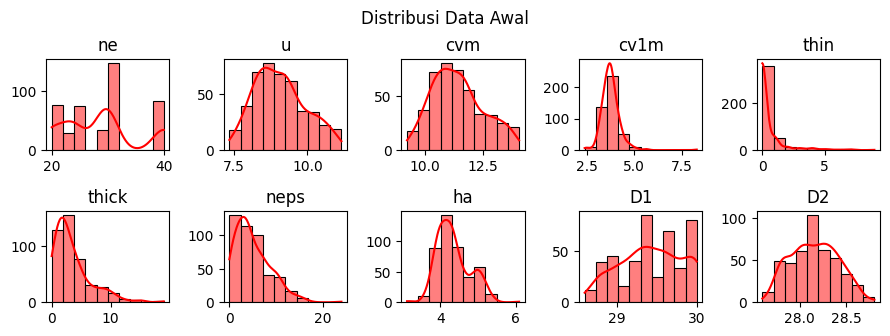

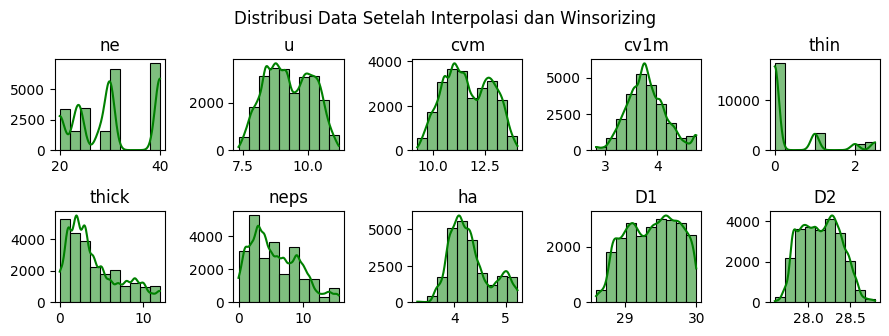

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(9, 6))
axes = axes.flatten()

for i, col in enumerate(data_awal.select_dtypes(include='number').columns):
    sns.histplot(data_awal[col], kde=True, ax=axes[i], color='red', bins=10)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(data_awal.select_dtypes(include='number').columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribusi Data Awal", y=1.02)
plt.show()


fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(9, 6))
axes = axes.flatten()

for i, col in enumerate(data.select_dtypes(include='number').columns):
    sns.histplot(data[col], kde=True, ax=axes[i], color='green', bins=10)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(len(data.select_dtypes(include='number').columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribusi Data Setelah Interpolasi dan Winsorizing", y=1.02)
plt.show()

## Korelasi (Spearman)

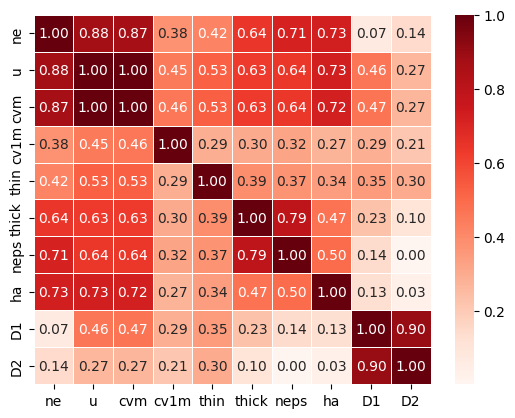

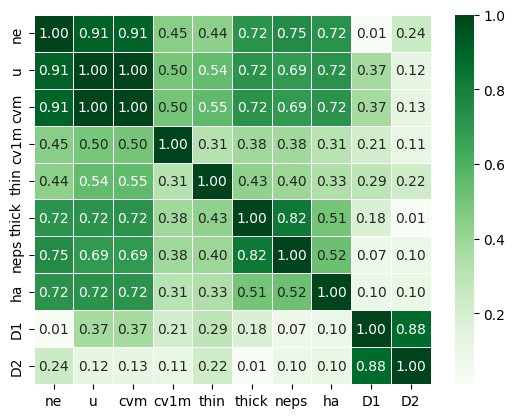

In [10]:
sns.heatmap(data_awal.select_dtypes(include='number').corr(method='spearman').abs(), annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.show()

sns.heatmap(data.select_dtypes(include='number').corr(method='spearman').abs(), annot=True, cmap='Greens', fmt=".2f", linewidths=0.5)
plt.show()

## Time Series Plot

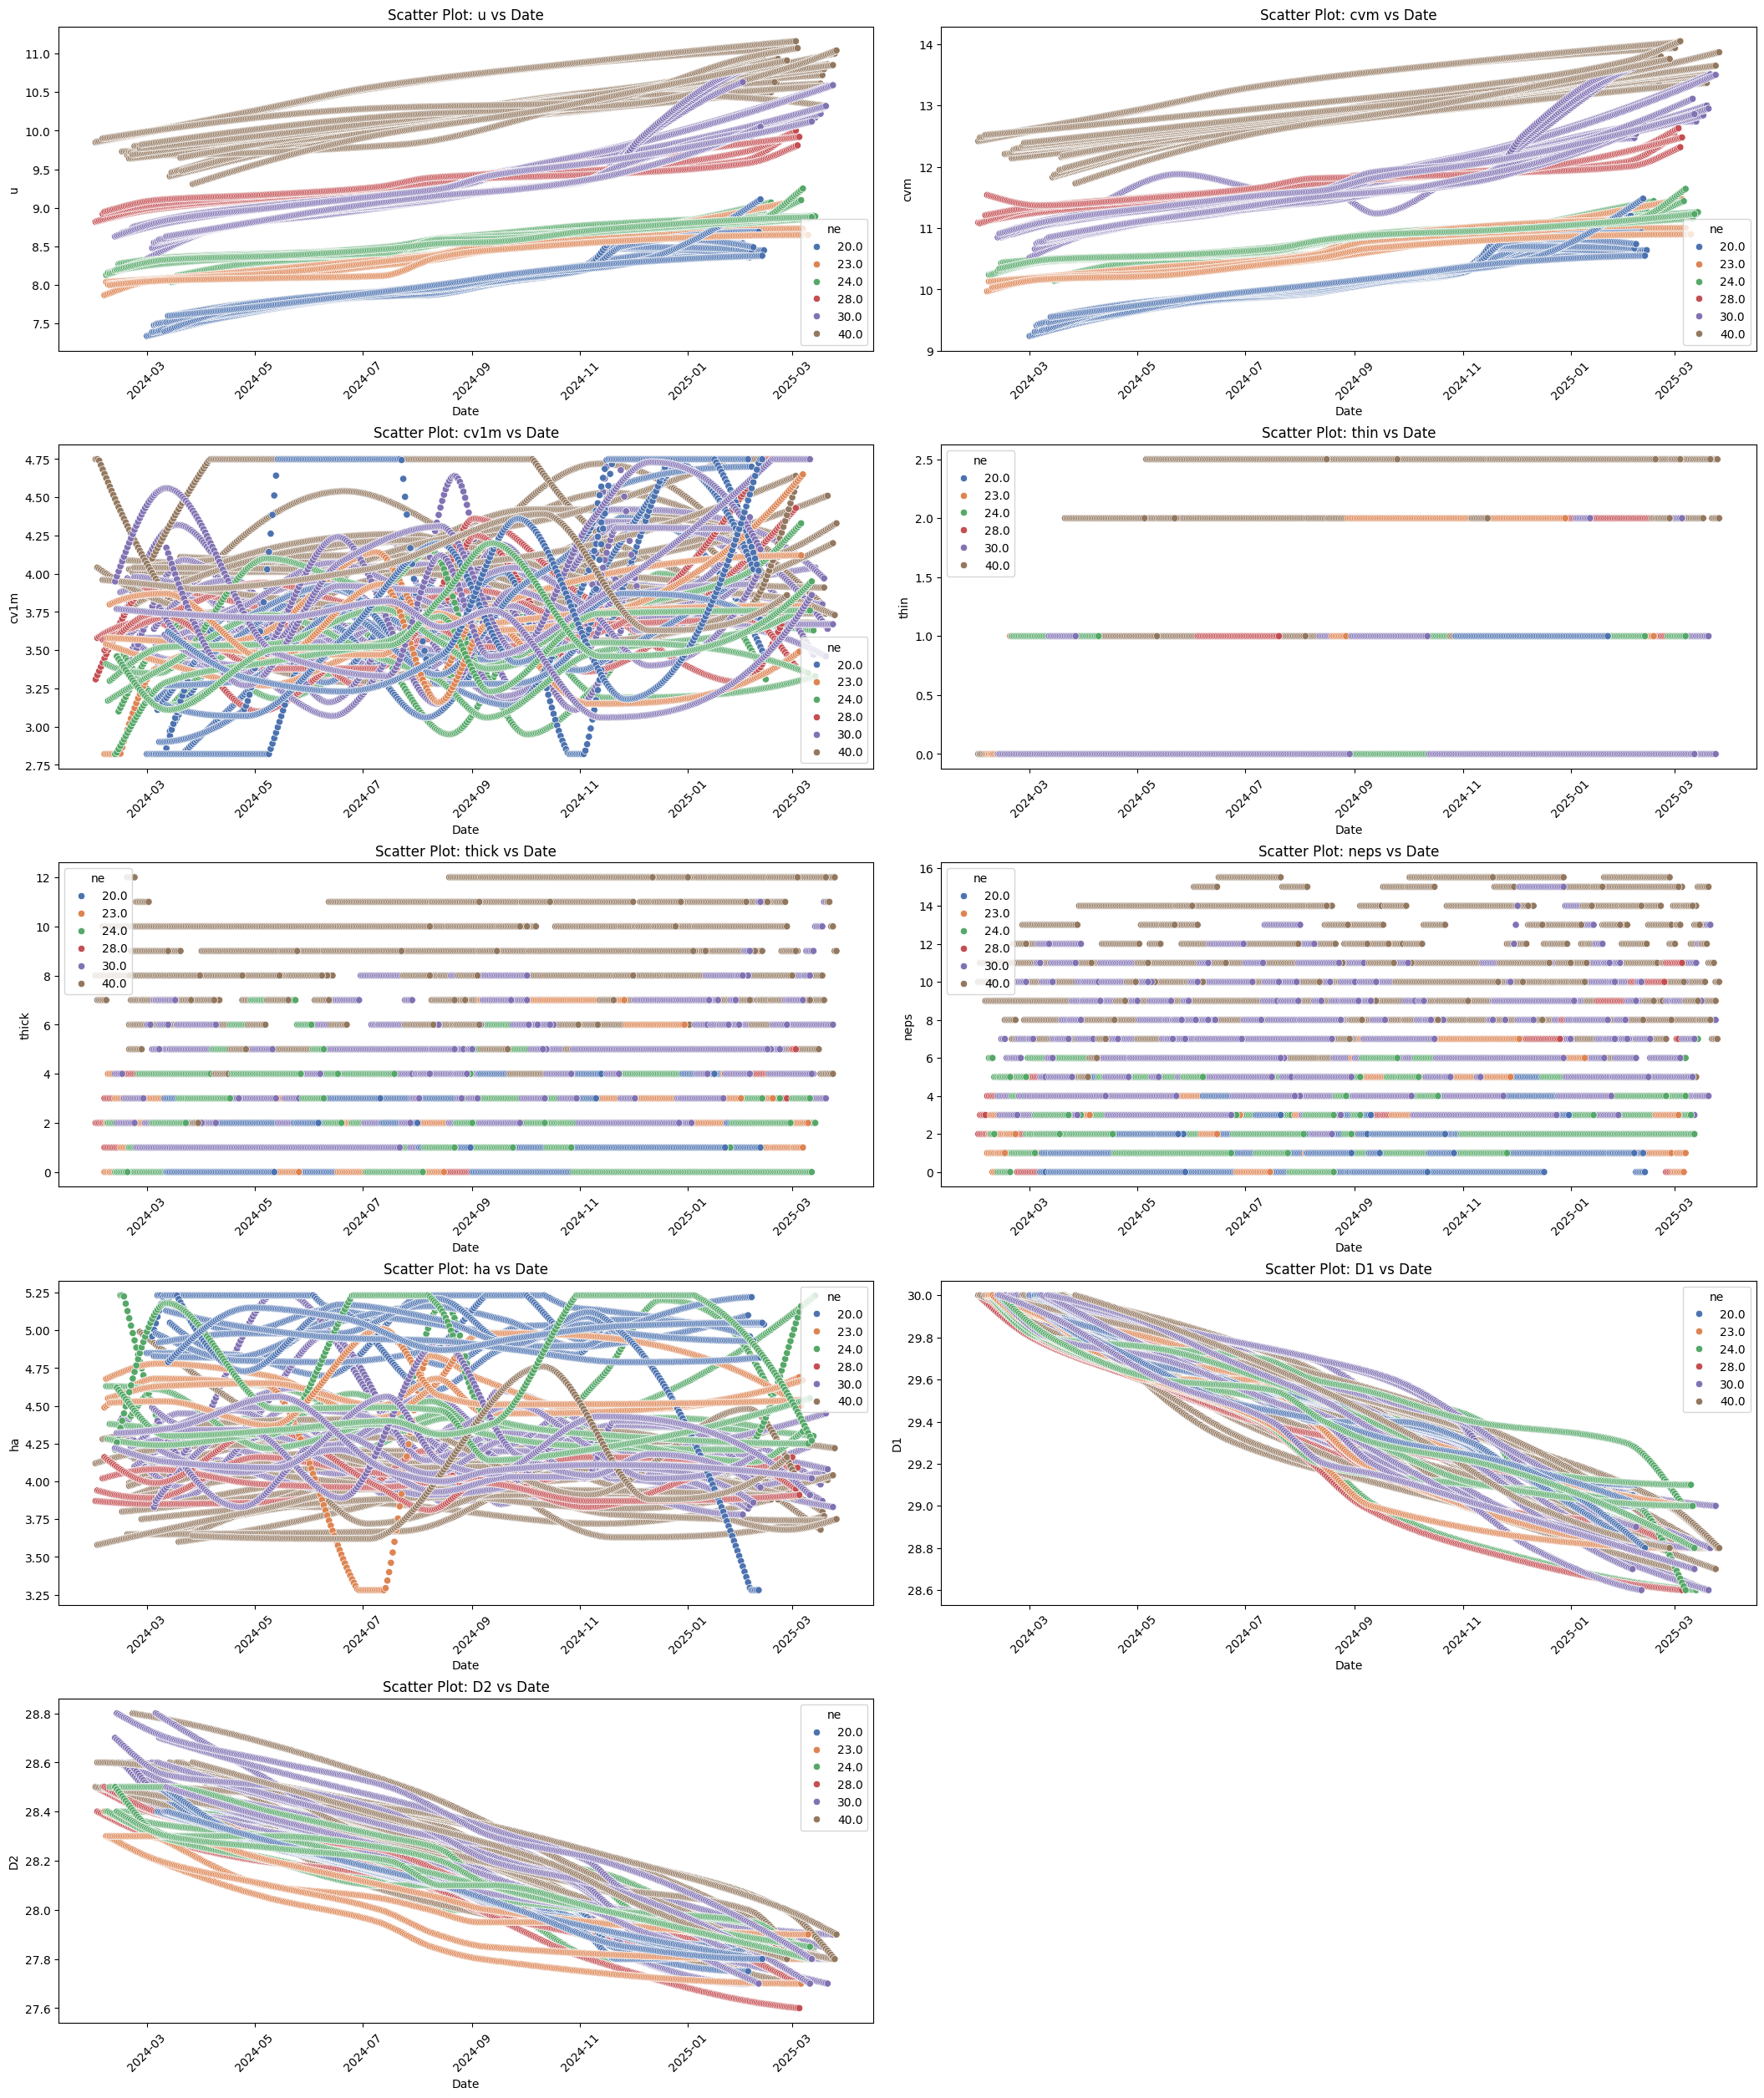

In [11]:
cols_to_plot = [col for col in data.columns if col not in ['Date', 'ne', 'RSF']]
n_cols = 2
n_rows = (len(cols_to_plot) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, n_rows * 5), constrained_layout=True)

for i, col in enumerate(cols_to_plot):
    ax = axes[i // n_cols, i % n_cols]
    sns.scatterplot(data=data, x='Date', y=col, hue='ne', palette='deep', ax=ax)
    ax.set_title(f'Scatter Plot: {col} vs Date')
    ax.tick_params(axis='x', rotation=45)

# Hapus subplot kosong jika ada
if len(cols_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()

### Ekspor Data

In [12]:
data_final.to_excel('DATAMODEL_2_clean.xlsx', index=False)